# Assignment 1 - Linear Algebra


In this exercise, you will investigate various aspects of linear algebra.

* Use appropriate functions
* Comment your code.
* Use numpy/scipy libraries where appropriate, except where explicitly stated.

For each question where you are asked to write some code, you will also be asked to _briefly_ describe what you have done in a text cell below.  


## Q1

In this part you will need to use the matrix inversion code based on Cramer's rule, posted in the matrix-inversion notebook on Blackboard. Cut and paste the necessary functions into the cell below.

In [1]:
import numpy as np
import scipy.linalg as lin
import math
from timeit import Timer
import functools as func
import matplotlib.pyplot as plt

def det2x2(m):
    if m.shape[0] != 2 or m.shape[1] != 2:
        raise Exception("Non2x2Matrix")
    
    return ( m[0][0]*m[1][1] ) - ( m[0][1]*m[1][0] )

def inverse2x2(m):
    if (m.shape[0] != 2 or m.shape[1] != 2):
        raise Exception("Non2x2Matrix")

    det = det2x2(m)
    tmp = np.empty([2,2])
    tmp[0][0] = m[1][1] / det
    tmp[0][1] = -1 * m[0][1] / det
    tmp[1][0] = -1 * m[1][0] / det
    tmp[1][1] = m[0][0] / det
    return tmp


def submatrix(m,i,j):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    # create a new matrix
    n = m.shape[0]-1
    tmp = np.empty([n,n])
    
    # get the indices of the matrix that will be used
    tmpi = list(range(m.shape[0]))
    del tmpi[i]
    tmpj = list(range(m.shape[1]))
    del tmpj[j]
    
    for ii in range(n):
        for jj in range(n):
            tmp[ii][jj] = m[tmpi[ii]][tmpj[jj]]

    return tmp

def det(m):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    if (m.shape[0]==2):
        return det2x2(m)
        
    else:
        tmp = 0
        # use 0-th row to calculate determinant
        for j in range(m.shape[0]):
            tmp = tmp + (math.pow(-1,j) * m[0][j] * det(submatrix(m,0,j)))
    
    return tmp

def adjugate(m):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    tmp = np.empty(m.shape)
    
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            # note the order of indices below !
            tmp[j][i] = (math.pow(-1,i+j) * det(submatrix(m,i,j)))
    return tmp

def inverse(m):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    if m.shape[0]==2:
        return inverse2x2(m)
    
    d = det(m)        
    c = adjugate(m)
    return np.true_divide(c,d)

## 1a)
Verify that the code produces the correct result for a single _randomly_ generated 4x4 matrix. Make sure you account for possible rounding error due to limited floating point precision. 

In [2]:
#generate random 4x4 matrix (elements have values between 0 and 1)
rand_matrix = np.random.rand(4,4)
assert(np.allclose(inverse(rand_matrix), lin.inv(rand_matrix), atol=1e-19))

## 1b)
Plot the cpu-time taken to solve a randomly generated simultaneous equation as a function of the matrix order N. Your plot should contain 3 lines, for each of the following methods :
1. the matrix inversion function above based on Cramer's rule
2. LU decomposition using scipy
3. SVD decomposition using scipy

Note that you will need to generate both a random NxN matrix, and a random set of solutions. You will need to think about how you're going to handle errors (eg. if you generate a random matrix that is singular). You will need to look up the LU and SVD decomposition routines in the scipy reference manual (https://docs.scipy.org/doc/scipy/reference/), and make sure that your treatment of each routine is "fair", i.e. performs the same calculation.

You may want to read up on these methods in Numerical Recipes. The 3rd edition is available free online at http://numerical.recipes/oldverswitcher.html. LU decomposition is on p48 and SVD decomposition is on p65 in this edition.

Finally, write a paragraph describing your code in the text cell below : how you designed the code, what choices you had to make, and why - in particular how you deal with the issues raised above.

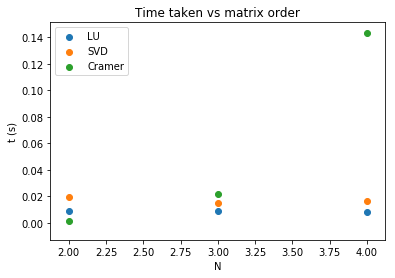

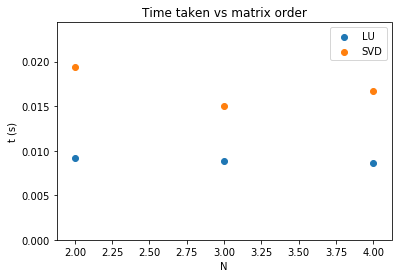

In [3]:
#solve linear simultaneous equations using LU decomposition
def luSolve(m, sol):
    
    lu, piv = lin.lu_factor(m,overwrite_a=True)
    x = lin.lu_solve((lu, piv),sol)
    return x
    
    
#solve system using SVD
def svdSolve(m, sol):
    
    u,s,v = lin.svd(m)
    
    #compute sigma-plus matrix
    s_plus = np.array([i ** (-1) for i in s if i != 0])
    s_plus = np.diagflat(s_plus)
    
    #find solution
    x = v.T @ s_plus.T @ u.T @ sol
    return x


#solve using Cramer's rule algorithm
def cramerSolve(m, sol):
    
    x = inverse(m) @ sol
    return x



def testAlgs(N, num, reps):
    lu_times = []
    cramer_times = []
    svd_times = []
    
    for i in range(2,N):
        
        rand_matrix = np.random.rand(i,i)
        
        #ensure non-singular matrix generated
        while lin.det(rand_matrix) == 0:
            rand_matrix = np.random.rand(i,i)
        
        s = np.random.rand(i,1)
        
        try:
            lu_times.append(min(Timer(func.partial(luSolve,
                                               rand_matrix, s))
                            .repeat(repeat=reps, number=num)))
            cramer_times.append(min(Timer(func.partial(cramerSolve,
                                                  rand_matrix, s))
                            .repeat(repeat=reps, number=num)))
            svd_times.append(min(Timer(func.partial(svdSolve,
                                                  rand_matrix, s))
                            .repeat(repeat=reps, number=num)))
        except Exception as e:
            print(str(e))
            testAlgs(N, num, reps)
            break
        
        
    return lu_times, svd_times, cramer_times

        
lu_times, svd_times, cramer_times = testAlgs(5, 100, 5)

#plot data
plt.scatter([i for i in range(2, len(lu_times) + 2)],
            lu_times, label='LU')
plt.scatter([i for i in range(2, len(svd_times) + 2)],
            svd_times, label='SVD')
plt.scatter([i for i in range(2, len(cramer_times) + 2)],
            cramer_times, label='Cramer')

#format plot
plt.xlabel('N')
#plt.ylim(bottom=0)
plt.ylabel('t (s)')
plt.legend()
plt.title('Time taken vs matrix order')
plt.show()

plt.cla()
plt.scatter([i for i in range(2,len(lu_times)+2)], lu_times, label='LU')
plt.scatter([i for i in range(2,len(svd_times)+2)], svd_times, label='SVD')
plt.xlabel('N')
plt.ylabel('t (s)')
plt.ylim(bottom=0)
plt.legend()
plt.title('Time taken vs matrix order')
plt.show()


Instead of allowing there to be a possibility of generating a singular matrix, I ensure that a non-singular matrix is generated before it is passed to the Timer. I also eliminate the possibility of a non-square matrix by providing only one variable parameter, N, for the matrix order.

## 1c)
Now discuss the results you obtained above. Can you explain the results in terms of the number of operations performed by each function ?  You might want to look up the **computational complexity** of these algorithms.  How well do the curves conform to your explanation ?

Cramer's rule: Computational complexity is $\mathcal{O}(n!\cdot{n})$ since the function for calculating the determinant is $\mathcal{O}(n!)$, and the adjugate function performs the same order of operations, but another $n$ times. 

LU Decomposition: Computational complexity is $\mathcal{O}(n^{3})$


## 1d)
Next, we will study the precision of the algorithms - in particular, for near singular matrices. Write a routine that will estimate (and plot) the precision of the result when solving the equation below, for small values of k. Your function should do this for all 3 routines studied in Q1b).

\begin{eqnarray*}
x + y + z & = & 5 \\
x + 2y - z & = & 10 \\
2x + 3y +kz & = & 15 
\end{eqnarray*}

You will need to choose a method to estimate the precision, given that the equation solvers will return values for all of x, y, and z.

As before, describe the functionality of the code and the choices you made writing it in the text cell below.

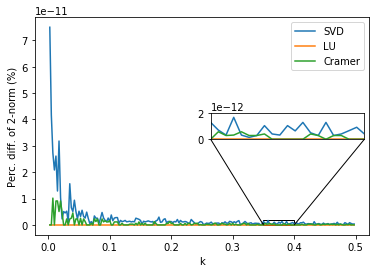

In [4]:
def estPrecision(k):
    
    
    matrix = np.array([[1,1,1],[1,2,-1],[2,3,k]])
    solution = np.array([5,10,15])
    
    #analytical solution
    x = np.asarray([0, 5, 0])
    x_mag = np.linalg.norm(x)
    
    #computational solution for given k
    x_svd = svdSolve(matrix, solution)
    x_lu = luSolve(matrix, solution)
    x_cramer = cramerSolve(matrix, solution)
    
    #calculate fractional differences between computational
    #and analytical solutions
    diff_svd = np.linalg.norm(x_svd - x)/x_mag 
    diff_lu  = np.linalg.norm(x_lu - x)/x_mag
    diff_cramer = np.linalg.norm(x_cramer - x)/x_mag
        
    return diff_svd, diff_lu, diff_cramer


svd_prec = []
lu_prec = []
cramer_prec = []
k_vals = []

#estimate precision for a range of small k values
for i in np.arange(0.0025, 0.5, 0.0025):
    svd, lu, cramer = estPrecision(i)
    svd_prec.append(svd*100)
    lu_prec.append(lu*100)
    cramer_prec.append(cramer*100)
    k_vals.append(i)


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
fig, ax = plt.subplots()
ax.plot(k_vals, svd_prec, label='SVD')
ax.plot(k_vals, lu_prec, label='LU')
ax.plot(k_vals, cramer_prec, label='Cramer')
#plt.xlim(left = 0,right=2e-14)
plt.xlabel('k')
plt.ylabel('Perc. diff. of 2-norm (%)')
plt.legend()

ax_inset = zoomed_inset_axes(ax, 5, loc=7)
ax_inset.plot(k_vals, svd_prec)
ax_inset.plot(k_vals, lu_prec)
ax_inset.plot(k_vals, cramer_prec)

x1, x2, y1, y2 = 0.35, 0.4, 0, 2e-14
ax_inset.set_xlim(x1, x2)
ax_inset.set_ylim(y1, y2)
plt.xticks(visible=False)
ax_inset.set_yticks(ticks=[0,2e-12])

ax_inset.ticklabel_format(style='sci')
ax_inset.tick_params(axis='x',length=0)
mark_inset(ax, ax_inset, loc1=4, loc2=3, fc='none')

plt.show()

The objective of this piece of code is to estimate the precision of the different algorithms for the set of equations given above, so I have kept the function above specific to that case as opposed to some arbitrary set of equations and solutions.

The metric by which the precision is measured in the above is the difference in the $2$-norm between the actual (analytical) solution vector $(x, y, z)$ and the computed solution vector.

Inset, zoomed plot created to show that the magnitude of difference is still of the order of $\sim10\%$ or more, for the slightly larger $k$ values than at which the largest difference occurs (since the spike at $k\sim0.25\times10^{-14}$ dwarfs the rest of the plot).

## 1e)
Discuss your results in the test box below. You should describe the behaviour of each algorithm as k goes to 0, and explain what is happening in each case. How would these results affect your choice of algorithm ?

**Use this cell for your answer**

## Q2
This question is on eigenvalue problems.  

## 2a)
In this part you should write a function that will find the eigenvector/eigenvalues of a matrix A using "Rayleigh quotient iteration". The algorithm is as follows :

1. An initial values for the eigenvalue $\mu_0$ and eigenvector $b_0$ must be supplied

2. The next approximation of the eigenvector is given by :
$$b_{i+1} = \frac{(A-\mu_i I)^{-1}b_i}{|(A-\mu_i I)^{-1}b_i|}$$

3. The corresponding eigenvalue is given by :

$$\mu_{i+1} = \frac{b^*_{i+1}Ab_{i+1}}{b^*_{i+1}b_{i+1}}$$

4. Now iterate steps 2 and 3 until convergence is reached for a specified precision, ie.
$$\mu_{i+1} - \mu < a_{tol}$$

(Note that the numerator in 2. can also be found by solving $(A-\mu_i I)x = b$) 

Your function should take arguments for the matrix A, the initial estimates of eigenvalue and eigenvector, and the precision required (ie. a convergence condition).

You should use vector and matrix algebra routines from numpy and scipy.linalg for the operations described above.

Explain the choices you made when writing this code in the text cell below.

In [13]:
def rayleigh(A, mu_0, b_0, a_tol):
    mu = mu_0
    b = b_0
    mu_prev = mu_0
    b_prev = b_0
    while (abs(mu - mu_prev) >= a_tol) or (mu == mu_0):
        
        mu_prev = mu
        
        x = lin.inv(A - mu_prev * np.eye(A.shape[0], A.shape[1])) @ b_prev
        x_mag = np.linalg.norm(x)
        
        b = x / x_mag
        b *= 1/b[0]
        
        mu = (np.conj(b).T @ A @ b) / (np.conj(b).T @ b)
        print(mu)
    return mu, b
    
#M = np.random.rand(3,3)
#M = M + M.T - np.diag(M.diagonal())
#rayleigh(M,1,np.array([1,1,1]),1e-14)

**Use this cell for text**

### 2b)
Now test your function using a matrix with known eigenvalues / vectors. You can use :
$$\left(\begin{array}{ccc} 1 & 2 & 3 \\ 1 & 2 & 1 \\ 3 & 2 & 1 \end{array}\right)$$

The leading eigenvalue of this matrix is $\sqrt{5}+3$, which corresponds to the eigenvector :
$$\left(\begin{array}{c} 1 \\ \frac{\sqrt(5)}{2} \\ 1 \end{array}\right)$$

In [14]:
# use this cell for code
test_matrix = np.array([[1,2,3],[1,2,1],[3,2,1]])
#test_matrix = np.random.rand(3,3)
print(test_matrix)
print(rayleigh(test_matrix, 1, np.array([1,-1,1]), 1e-19)[0])
#mu, b = rayleigh(test_matrix, 1, np.array([1,-1,1]), 1e-19)

np.allclose(rayleigh(test_matrix, 3, np.array([1,1,1]), 1e-19)[1], np.array([1,np.sqrt(5)/2 - 1/2,1]),atol=1e-19)
np.allclose(rayleigh(test_matrix, 3, np.array([1,1,1]), 1e-19)[0], np.sqrt(5)+3,atol=1e-19)

[[1 2 3]
 [1 2 1]
 [3 2 1]]
0.744186046511628
0.7655633834020118
0.7637970770972824
0.7639431839944416
0.7639310993120826
0.7639320988587794
0.7639320161844537
0.763932023022598
0.7639320224570026
0.7639320225037841
0.7639320224999145
0.7639320225002345
0.7639320225002083
0.7639320225002104
0.7639320225002102
0.7639320225002102
0.7639320225002102
4.842105263157894
5.2082241483571865
5.234345907812369
5.235962435802858
5.23606151271829
5.236067581523936
5.23606795324583
5.236067976014208
5.236067977408796
5.236067977494216
5.236067977499448
5.2360679774997685
5.236067977499788
5.23606797749979
5.23606797749979
4.842105263157894
5.2082241483571865
5.234345907812369
5.235962435802858
5.23606151271829
5.236067581523936
5.23606795324583
5.236067976014208
5.236067977408796
5.236067977494216
5.236067977499448
5.2360679774997685
5.236067977499788
5.23606797749979
5.23606797749979


True

## 2c)
Your function should find the largest eigenvalue of a matrix, along with it's corresponding eigenvector. Given that eigenvectors of a real symmetric matrix are orthogonal, can you think of a method to find the 2nd eigenvector of the above matrix ? How could you extend this to non-symmetric matrices ? Discuss in the text box below, and use the code cell below that if you want to write any code to demonstrate your answer. 

Could continually make random initial guesses and use Rayleigh Quotient Iteration until an eigenvalue/eigenvector different from the first has been found. For a $3x3$ matrix such as the one above, this is all that is required, since then orthogonality of the 3 eigenvectors can be used to find the final eigenvector.

We could also be slightly smarter about the initial guess when finding the second eigenvector, as we know it has to be orthogonal to the first. This means, for example, that we could generate a random vector linearly independent from the first eigenvector, and employ the Gram-Schmidt procedure to achieve a better guess at the second eigenvector (assuming it is closer). Perhaps we may have to do this several times if the guess keeps converging on the first eigenvector found.

For higher order matrices of order $M$, the same has to be done, but in general we have to find $M-1$ eigenvectors in order to find the final one.

However, there are other (presumably much better) ways of finding the other eigenvalues, namely 'deflation' techniques.
I will implement Hotelling's Deflation method.

In [15]:
#symmetric matrix
test_matrix = np.array([[1,2,4],[2,2,2],[4,2,1]])

#find an eigenpair
mu_1, b_1 = rayleigh(test_matrix, 2, np.array([1,1,1]), 1e-19)
print(mu_1, b_1)

#generate random eigenvector guess
guess = np.random.rand(3,)

#produce orthogonal vector to b_1 via Gram-Schmidt
guess -= ((guess.dot(b_1)) * b_1)/(b_1.dot(b_1))
print(guess)

#Hotelling deflation with reasonable guess
mu_2, b_2 = rayleigh(test_matrix - mu_1 * (b_1 @ b_1.T), 3, guess, 1e-19)
print(mu_2, b_2)

#find final eigenvector by cross-product
b_3 = np.cross(b_1, b_2)
b_3 *= (1/b_3[0])
print(b_3)



6.444444444444445
6.70150071201665
6.701562118713198
6.701562118716424


LinAlgError: singular matrix

## Q3

For this question you should write a function that will find the eigenvalues of the coupled system of oscillators shown below.

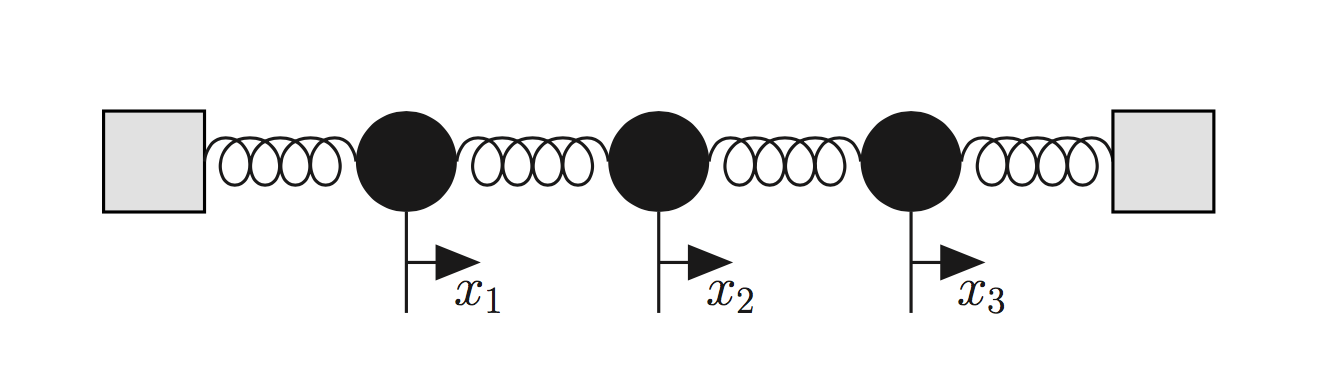

If the displacement of the $i$th mass from its equilibrium position is denoted as $x_i$, the force on the mass is given by the tension in the two springs as :

$$F_i = −k(x_i − x_i−1) + k(x_i+1 − x_i) = −k(2x_i − x_i−1 − x_i+1)$$

We can assume that there are normal mode solutions, i.e. solutions of the form $x_i = z_i e^{i\omega t}$ in which all masses oscillate with the same frequency $\omega$ but with unknown phasors $z_i$. Then the above equation becomes :

$$F_i = m\ddot{x}_i = −m\omega^2x_i = −k(2x_i − x_i−1 − x_i+1)$$

This is one row of a matrix equation describing the entire system :

$$m\omega^2x_i \left(\begin{array}{c} \vdots \\ \\ x_i \\ \\ \vdots \end{array}\right) = 
\left(\begin{array}{ccccccc} & & & \vdots & & & \\ \cdots & 0 & -1 & 2 & 1 & 0 & \cdots \\ & & & \vdots & & & \end{array}\right)
\left(\begin{array}{c} \vdots \\ x_{i-1} \\ x_i \\ x_{i+1} \\ \vdots \end{array}\right)
$$

This example is a typical eigenvalue problem, in that many of the matrix elements are zero, which can greatly simplify the computational challenge and make even large systems solvable.

## 3a)
Write a function in the cell below that will calculate the normal modes and corresponding oscillation frequencies for a system of three identical masses connected by identical springs as shown above.

As for previous questions, briefly describe how your code works and the choices you made when writing it in the text cell below.

In [19]:
# use this cell for code

def normal_modes(coeff_matrix):
    eig_vals, eig_vecs = np.linalg.eig(coeff_matrix)
    
    return eig_vals, eig_vecs
    
coeffs = np.array([[2,-1,0],[-1,2,-1],[0,-1,2]])
#x = np.array([])
print("eigenvalues:", normal_modes(coeffs)[0])
print("eigenvectors:", normal_modes(coeffs)[1])




eigenvalues: [3.41421356 2.         0.58578644]
eigenvectors: [[-5.00000000e-01 -7.07106781e-01  5.00000000e-01]
 [ 7.07106781e-01  4.05405432e-16  7.07106781e-01]
 [-5.00000000e-01  7.07106781e-01  5.00000000e-01]]


**Use this cell for text**

## 3b)
Discuss your results above. Describe the physical interpretation of each mode you have found ? How does the behaviour change if the springs at either end are removed ?

**Use this cell for your answer**